In [1]:
import keras
import numpy as np
import tensorflow as tf
from keras import layers
from sklearn.metrics import classification_report
from keras import layers, models, regularizers
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
import keras_tuner as kt
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import torch
import torchaudio
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, train_test_split

2024-07-12 20:12:17.527410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 20:12:17.541412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 20:12:17.541433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 20:12:17.551018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import numpy as np
physical_devices = tf.config.list_physical_devices('GPU')


class AudioProcessor:
    def __init__(self, path_df, path_audio):
        self.path_df = "df_filter.csv"
        self.path_audio = path_audio
        self.load_data()

    def load_data(self):
        df = pd.read_csv(self.path_df)
        df["file_cut_path"] = self.path_audio + df["file_name"]
        df = df.reset_index(drop=True)
        self.dataset = df["file_cut_path"]

        self.log = []
        for i in range(len(df)):
            self.log.append(torch.load("torch_files14/" + f"torch_files14file{i}.pt"))

        self.y = df["label"]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.log, self.y, random_state=42, stratify=self.y
        )

        self.process_tensors()

    def process_tensors(self):
        for i in range(len(self.X_train)):
            self.X_train[i] = self.X_train[i][0].detach().numpy()
            self.X_train[i] = np.concatenate(self.X_train[i])

        for i in range(len(self.X_test)):
            self.X_test[i] = self.X_test[i][0].detach().numpy()
            self.X_test[i] = np.concatenate(self.X_test[i])

2024-07-12 20:12:21.150907: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-12 20:12:21.151832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-12 20:12:21.151866: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
processor = AudioProcessor(path_df="./df_filter.csv", path_audio="../audios/")
X_train   = processor.X_train
y_train  = processor.y_train
X_test = processor.X_test
y_test = processor.y_test

X_train_formated = np.array(X_train)
y_train_formated = np.array(y_train)
X_test_formated = np.array(X_test)
y_test_formated = np.array(y_test)

print("Datos cargados")

Datos cargados


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Asumiendo que ya tienes estos datos
processor = AudioProcessor(path_df="./df_filter.csv", path_audio="../audios/")
X_train = processor.X_train
y_train = processor.y_train
X_test = processor.X_test
y_test = processor.y_test

X_train_formated = np.array(X_train)
y_train_formated = np.array(y_train)
X_test_formated = np.array(X_test)
y_test_formated = np.array(y_test)

print("Datos cargados")

# Normalizar los datos
X_train_formated = (X_train_formated - X_train_formated.mean(axis=0)) / X_train_formated.std(axis=0)
X_test_formated = (X_test_formated - X_test_formated.mean(axis=0)) / X_test_formated.std(axis=0)

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_formated, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_formated, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_formated, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_formated, dtype=torch.float32).view(-1, 1)

# Crear un DataLoader para los datos de entrenamiento
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# Definir el modelo con más capas y Dropout
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(X_train_tensor.shape[1], 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.layer3(x))
        return x

model = BinaryClassifier()

# Definir la función de pérdida y el optimizador
criterion = nn.BCELoss()  # Pérdida de entropía cruzada binaria
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Usar Adam como optimizador

# Entrenar el modelo
num_epochs = 100

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Adelante
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Atrás
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Imprimir la pérdida cada 10 épocas
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluar el modelo
with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_train = (y_pred_train > 0.5).float()  # Convertir las predicciones en etiquetas binarias
    train_accuracy = (y_pred_train == y_train_tensor).float().mean()
    print(f'Train Accuracy: {train_accuracy:.4f}')
    
    y_pred_test = model(X_test_tensor)
    y_pred_test = (y_pred_test > 0.5).float()  # Convertir las predicciones en etiquetas binarias
    test_accuracy = (y_pred_test == y_test_tensor).float().mean()
    print(f'Test Accuracy: {test_accuracy:.4f}')

Datos cargados
Epoch [10/100], Loss: 0.1021
Epoch [20/100], Loss: 0.0223
Epoch [30/100], Loss: 0.1836
Epoch [40/100], Loss: 0.2002
Epoch [50/100], Loss: 0.6744
Epoch [60/100], Loss: 0.0012
Epoch [70/100], Loss: 0.0813
Epoch [80/100], Loss: 0.1594
Epoch [90/100], Loss: 0.0021


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Asumiendo que ya tienes estos datos
processor = AudioProcessor(path_df="./df_filter.csv", path_audio="../audios/")
X_train = processor.X_train
y_train = processor.y_train
X_test = processor.X_test
y_test = processor.y_test

X_train_formated = np.array(X_train)
y_train_formated = np.array(y_train)
X_test_formated = np.array(X_test)
y_test_formated = np.array(y_test)

print("Datos cargados")

# Normalizar los datos
X_train_formated = (X_train_formated - X_train_formated.mean(axis=0)) / X_train_formated.std(axis=0)
X_test_formated = (X_test_formated - X_test_formated.mean(axis=0)) / X_test_formated.std(axis=0)

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_formated, dtype=torch.float32).unsqueeze(1)  # Añadir dimensión de canal
y_train_tensor = torch.tensor(y_train_formated, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_formated, dtype=torch.float32).unsqueeze(1)  # Añadir dimensión de canal
y_test_tensor = torch.tensor(y_test_formated, dtype=torch.float32).view(-1, 1)

# Crear un DataLoader para los datos de entrenamiento
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# Definir el modelo CNN con más regularización
class AudioCNN(nn.Module):
    def __init__(self):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * (X_train_tensor.shape[2] // 2) * (X_train_tensor.shape[3] // 2), 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * (X_train_tensor.shape[2] // 2) * (X_train_tensor.shape[3] // 2))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

model = AudioCNN()

# Definir la función de pérdida y el optimizador con L2 regularización
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Añadir weight_decay para L2 regularización

# Entrenar el modelo con early stopping
num_epochs = 100
best_loss = float('inf')
patience = 10
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        # Adelante
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Atrás
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluar en el conjunto de prueba
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        loss_test = criterion(outputs_test, y_test_tensor)
    
    # Imprimir la pérdida cada 10 épocas
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {loss_test.item():.4f}')
    
    # Early stopping
    if loss_test < best_loss:
        best_loss = loss_test
        trigger_times = 0
    else:
        trigger_times += 1
    
    if trigger_times >= patience:
        print('Early stopping at epoch:', epoch+1)
        break

# Evaluar el modelo final
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_train = (y_pred_train > 0.5).float()  # Convertir las predicciones en etiquetas binarias
    train_accuracy = (y_pred_train == y_train_tensor).float().mean()
  


In [20]:
X_train = np.array(X_train)
X_train_formated = X_train.reshape((1794, 128, 1192)) 

timesteps = 128  # chosen timesteps
features = 1192  # calculated features per timestep
input_shape = (timesteps, features)
num_classes = 1  # assuming binary classification

ValueError: cannot reshape array of size 91240448 into shape (1794,128,1192)

In [5]:
input_shape = (152576,)
num_classes = 1  # assuming binary classification

In [6]:
X_train_formated.shape

(1794, 128, 1192)

In [7]:
y_train_formated.shape

(1794,)

In [32]:
model = models.Sequential([
    layers.Input(shape=(timesteps, features)), 
    layers.LSTM(64, return_sequences=True, input_shape=(None, 152576)),
    layers.LSTM(32, return_sequences=False),
    layers.Dense(60, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
    layers.Dropout(0.2),
    layers.Dense(30, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
    layers.Dense(num_classes, activation="sigmoid")  # Capa de salida con activación sigmoid para binaria
])
#hecha

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model = models.Sequential([
    layers.Flatten(input_shape=(152576,)),
    layers.Dense(60, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
    layers.Dense(30, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
    layers.Dense(num_classes, activation="sigmoid")  # Capa de salida con activación sigmoid
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model = models.Sequential([
    layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=(timesteps, features)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(num_classes, activation="sigmoid")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model = models.Sequential([
    # Añadir capas convolucionales para extraer características
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, features)),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    
    # Capas LSTM para capturar dependencias temporales
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64, return_sequences=False),
    
    # Capas densas para la clasificación final
    layers.Dense(60, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
    layers.Dropout(0.2),
    layers.Dense(30, activation="relu", kernel_regularizer=regularizers.l2(0.02)),
    layers.Dense(num_classes, activation="sigmoid")  # Capa de salida con activación sigmoid para clasificación binaria
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-12 18:31:14.774028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-12 18:31:14.774103: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-12 18:31:14.774130: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kerne

In [ ]:
model = models.Sequential([
    # Añadir capas Bidirectional LSTM
    layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=(timesteps, features)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    
    # Capas densas para la clasificación final
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    
    layers.Dense(num_classes, activation="sigmoid")  # Capa de salida con activación sigmoid para clasificación binaria
])

In [7]:
model = models.Sequential([
    # Añadir capas Bidirectional LSTM
    layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=(timesteps, features)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    
    # Capas densas para la clasificación final
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    
    layers.Dense(num_classes, activation="sigmoid")  # Capa de salida con activación sigmoid para clasificación binaria
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
model = models.Sequential([
    layers.Flatten(input_shape=(152576,)),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="softmax")  # Capa de salida con activación sigmoid para clasificación binaria
])
#hecha


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-07-03 20:34:20.427096: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 20:34:20.427179: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 20:34:20.427211: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-0

In [9]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(learning_rate= 0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-6,)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=0, patience=60)
model.compile(loss=loss, optimizer=optimizer ,metrics=['accuracy'])
model.summary()
# Train the model
history = model.fit(X_train_formated, y_train_formated, epochs=20, batch_size=2, validation_split=0.2, verbose=1, callbacks=[reduce_lr,early_stop])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │       228,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 124, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 62, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60)             │         3,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,265 (1.51 MB)

 Trainable params: 395,265 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

2024-07-12 18:31:17.809677: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 875786240 exceeds 10% of free system memory.
2024-07-12 18:31:18.461684: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 875786240 exceeds 10% of free system memory.


Epoch 1/20


2024-07-12 18:31:20.577906: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5685 - loss: 1.3997 - val_accuracy: 0.5766 - val_loss: 0.7013 - learning_rate: 0.0010
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5907 - loss: 0.6922 - val_accuracy: 0.5766 - val_loss: 0.6834 - learning_rate: 0.0010
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5849 - loss: 0.6812 - val_accuracy: 0.5766 - val_loss: 0.6825 - learning_rate: 0.0010
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5819 - loss: 0.6807 - val_accuracy: 0.5766 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5927 - loss: 0.6747 - val_accuracy: 0.5766 - val_loss: 0.6836 - learning_rate: 0.0010
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.5868 - loss: 0.6785 - val_accuracy: 0.5766 - val_loss: 0.6864 - learning_rate: 0.0010
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5912 - loss: 0.6725

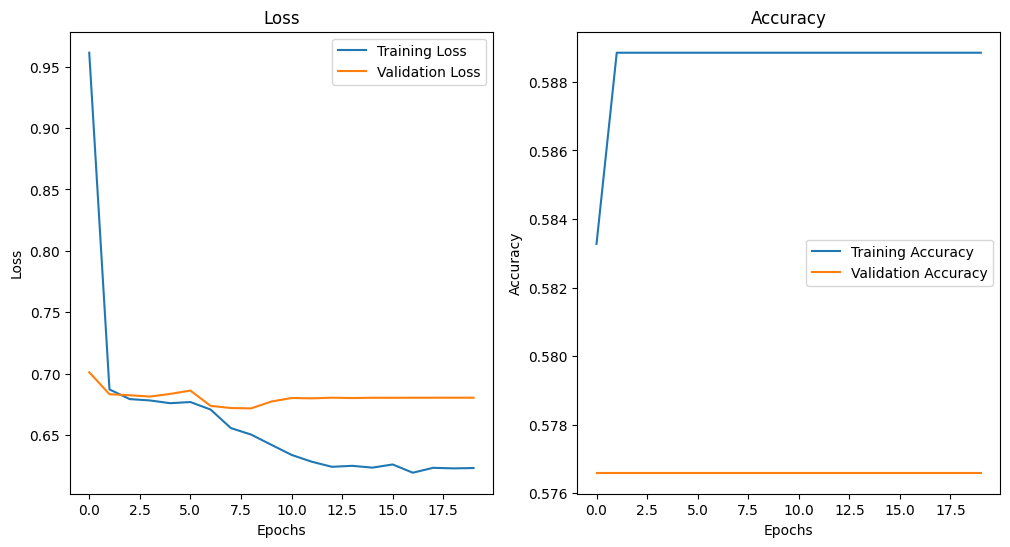

In [21]:
# Graficar las curvas de aprendizaje
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
#Model without callbacks
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(learning_rate= 0.001)
model.compile(loss=loss, optimizer=optimizer ,metrics=['accuracy'])
model.summary()
# Train the model
history = model.fit(X_train_formated, y_train_formated, epochs=20, batch_size=2, validation_split=0.2, verbose=1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 152576)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 60)             │     9,154,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,156,481 (34.93 MB)

 Trainable params: 9,156,481 (34.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6112 - loss: 0.6692 - val_accuracy: 0.5766 - val_loss: 0.6817
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5965 - loss: 0.6747 - val_accuracy: 0.5766 - val_loss: 0.6817
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5789 - loss: 0.6810 - val_accuracy: 0.5766 - val_loss: 0.6817
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5747 - loss: 0.6824 - val_accuracy: 0.5766 - val_loss: 0.6818
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5720 - loss: 0.6835 - val_accuracy: 0.5766 - val_loss: 0.6819
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5974 - loss: 0.6743 - val_accuracy: 0.5766 - val_loss: 0.6818
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5765 - loss: 0.6819 - val_accuracy: 0.5766 - val_loss: 0.6818
Epoch 8/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5750 - loss: 0.6824 - val_accuracy: 0.

In [26]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Check the current shape of X_test_formated
print(f"Current shape of X_test_formated: {X_test_formated.shape}")

# Reshape the data if necessary
X_test_formated = X_test_formated.reshape((-1, 128, 1192))

# Verify the new shape
print(f"New shape of X_test_formated: {X_test_formated.shape}")

# Proceed with prediction
y_pred = model.predict(X_test_formated, verbose=1)
y_pred_bool = np.round(y_pred)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_formated, y_test_formated)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Flatten the predictions and true labels if necessary
y_pred_bool_flat = y_pred_bool.flatten()
y_test_formated_flat = y_test_formated.flatten()

# Calculate the classification report
report = classification_report(y_test_formated_flat, y_pred_bool_flat, target_names=['0.0', '1.0'], output_dict=True, zero_division=0)
accuracy = accuracy_score(y_test_formated_flat, y_pred_bool_flat)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()
report_df['support'] = report_df['support'].astype(int)  # Convert support to int for better readability

# Add accuracy as a separate row
accuracy_row = pd.DataFrame({'precision': '', 'recall': '', 'f1-score': accuracy, 'support': len(y_test_formated_flat)}, index=['accuracy'])
report_df = pd.concat([report_df, accuracy_row])

# Print the DataFrame
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(report_df)


Current shape of X_test_formated: (598, 128, 1192)
New shape of X_test_formated: (598, 128, 1192)
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6051 - loss: 0.6502
Loss: 0.6675298810005188, Accuracy: 0.5852842926979065
             precision recall  f1-score  support
0.0               0.00   0.00      0.00      248
1.0               0.59   1.00      0.74      350
accuracy          0.59   0.59      0.59        0
macro avg         0.29   0.50      0.37      598
weighted avg      0.34   0.59      0.43      598
accuracy                           0.59      598


In [15]:
batch_size = 32
sequence_length = 128
features = 1192

# Reshape the test data
X_test_formated = X_test_formated.reshape((batch_size, sequence_length, features))

# Predict with the reshaped data
y_pred = model.predict(X_test_formated, verbose=1)
y_pred_bool = np.where(y_pred > 0.5, 1, 0).reshape(-1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_formated, y_test_formated)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Flatten y_test_formated to match the shape of y_pred_bool
y_test_formated_values = y_test_formated.flatten()

# Print the classification report
print(classification_report(y_test_formated_values, y_pred_bool))

ValueError: cannot reshape array of size 91240448 into shape (32,128,1192)

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │       228,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 124, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 62, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60)             │         3,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185,797 (4.52 MB)

 Trainable params: 395,265 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 790,532 (3.02 MB)

In [ ]:


# Define the HyperModel
def build_model(hp):
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')
    model = keras.Sequential()
    for i in range(0, hp.Int("num_layers", 1, 6)):
        model.add(
            tf.keras.layers.Dense(units = hp.Int(f"unit_{i}", 15, 80, step = 5), 
                                     activation='relu'
                                     )
            
        )
        model.add(
            tf.keras.layers.Dropout(hp.Float(f"drop_{i}", min_value=0.00, max_value=0.3, step=0.05)
                                     )
            
        )


# Tune the learning rate for the optimizer
    model.add(layers.Dense(1, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      metrics=['accuracy'])
    return model




In [ ]:
# Initialize the RandomSearch tuner
tuner = kt.Hyperband(
    hypermodel=build_model,
    objective="val_accuracy",
    max_epochs = 10,
    hyperband_iterations = 3,
    directory='tuner_dir-pt4',
    project_name='audio_classification-pt4'
)
# Display a summary of the search space
tuner.search_space_summary()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Run the hyperparameter search

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=1e-20)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=0, patience=60)

tuner.search(X_train_formated, y_train_formated, epochs=10, batch_size=2, validation_split=0.2, callbacks=[reduce_lr,early_stop],verbose=1)


# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test_formated, y_test_formated)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Predict and evaluate
y_pred = best_model.predict(X_test_formated, verbose=1)
y_pred_bool = np.round(y_pred)
y_test_formated_values=y_test_formated.reshape(-1, 1)
print(classification_report(y_test_formated_values, y_pred_bool))